# Importing Packages

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from sklearn.metrics import roc_curve, auc , precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization , concatenate , AveragePooling2D , Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing and Loading Dataset

In [3]:
train_dir = 'C:\\Users\\Ammar\\Desktop\\DLP_PROJ\\FYP\\Augmented_Train\\'

#test_dir = 'D:\\DATASET\\Testing\\'

In [4]:
classes = ['Actinic_Keratosis' , 'Benign_Keratosis' , 'Eczema' , 'Psoriasis' , 'Ringworm' , 'Melanocytic Nevi']

#image_count_train = len(list(train_dir.glob('*/*.jpg')))
for i in classes:
    myPath = os.path.join(train_dir , i) #train_dir + i + '\\'
    myPath = myPath + '/*.jpg'
    print('Training Images for ' + i + ' =' , end=' ')
    print(len(glob.glob(myPath)))



Training Images for Actinic_Keratosis = 7818
Training Images for Benign_Keratosis = 7758
Training Images for Eczema = 7530
Training Images for Psoriasis = 7180
Training Images for Ringworm = 7833
Training Images for Melanocytic Nevi = 7812


In [5]:
batch_size = 8
#img_size = (320 , 320)
img_size = 299

In [6]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [7]:
train_ds = image_dataset_from_directory(train_dir, 
                                        seed = 123, 
                                        image_size=(img_size,img_size) , 
                                        validation_split=0.2, 
                                        subset='training',
                                        batch_size=batch_size)



Found 45931 files belonging to 6 classes.
Using 36745 files for training.


In [8]:
val_ds = image_dataset_from_directory(train_dir,
                                      seed=123,
                                      validation_split = 0.2,
                                      subset = 'validation',
                                      image_size=(img_size,img_size),
                                      batch_size=batch_size)



Found 45931 files belonging to 6 classes.
Using 9186 files for validation.


#### Visualizing Data

Actinic_Keratosis
Benign_Keratosis
Eczema
Psoriasis
Ringworm
Melanocytic Nevi


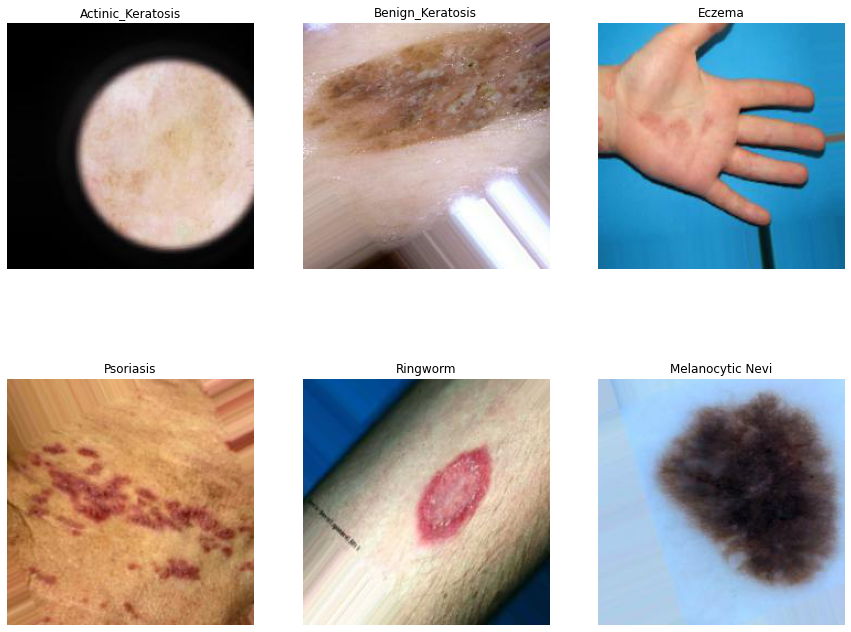

In [9]:
plt.figure(figsize=(15, 12))

for i, class_ in enumerate(classes):
    plt.subplot(2, 3, i+1)
    print(class_)
    data_path = os.path.join(str(train_dir), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[1]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

# Model Creation

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [12]:
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
)

irv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [13]:
irv2.trainable = False

In [14]:
for layer in irv2.layers[496:]:
    layer.trainable = True

In [15]:
# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output

In [16]:
for i, layer in enumerate(irv2.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [17]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [18]:
from tensorflow.keras import Model

output = Flatten()(conv)
output = Dense(6, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

Total params: 47,529,142
Trainable params: 27,795,030
Non-trainable params: 19,734,112
__________________________________________________________________________________________________


In [20]:
model.compile(optimizer='adamax' , loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
es = EarlyStopping(monitor ="val_loss", 
                   mode ="min", patience = 6, 
                   restore_best_weights = True)

checkpoint=  ModelCheckpoint(filepath ='IRV2+SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [22]:
history1 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 275s 352ms/step - loss: 1.7610 - accuracy: 0.3042 - val_loss: 1.7652 - val_accuracy: 0.2841
Epoch 2/5
574/574 [==============================] - 240s 414ms/step - loss: 1.6248 - accuracy: 0.3221 - val_loss: 1.6550 - val_accuracy: 0.3470
Epoch 3/5
574/574 [==============================] - 212s 365ms/step - loss: 1.5296 - accuracy: 0.3591 - val_loss: 1.5137 - val_accuracy: 0.3531
Epoch 4/5
574/574 [==============================] - 293s 510ms/step - loss: 1.5003 - accuracy: 0.3669 - val_loss: 1.4724 - val_accuracy: 0.3942
Epoch 5/5
574/574 [==============================] - 286s 484ms/step - loss: 1.4836 - accuracy: 0.3776 - val_loss: 1.3722 - val_accuracy: 0.3925


In [23]:
history2 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 171s 240ms/step - loss: 1.4474 - accuracy: 0.3811 - val_loss: 1.4091 - val_accuracy: 0.3881
Epoch 2/5
574/574 [==============================] - 222s 388ms/step - loss: 1.4093 - accuracy: 0.3948 - val_loss: 1.3189 - val_accuracy: 0.4161
Epoch 3/5
574/574 [==============================] - 270s 468ms/step - loss: 1.4002 - accuracy: 0.4033 - val_loss: 1.3263 - val_accuracy: 0.4196
Epoch 4/5
574/574 [==============================] - 309s 530ms/step - loss: 1.3861 - accuracy: 0.4051 - val_loss: 1.3129 - val_accuracy: 0.4205
Epoch 5/5
574/574 [==============================] - 250s 427ms/step - loss: 1.3506 - accuracy: 0.4225 - val_loss: 1.3525 - val_accuracy: 0.4240


In [24]:
history3 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 191s 257ms/step - loss: 1.3473 - accuracy: 0.4223 - val_loss: 1.3097 - val_accuracy: 0.4038
Epoch 2/5
574/574 [==============================] - 247s 430ms/step - loss: 1.3331 - accuracy: 0.4201 - val_loss: 1.2779 - val_accuracy: 0.4301
Epoch 3/5
574/574 [==============================] - 304s 530ms/step - loss: 1.3395 - accuracy: 0.4244 - val_loss: 1.2851 - val_accuracy: 0.4126
Epoch 4/5
574/574 [==============================] - 311s 542ms/step - loss: 1.3225 - accuracy: 0.4395 - val_loss: 1.2880 - val_accuracy: 0.4362
Epoch 5/5
574/574 [==============================] - 295s 504ms/step - loss: 1.3342 - accuracy: 0.4312 - val_loss: 1.3302 - val_accuracy: 0.4143


In [25]:
history4 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 220s 290ms/step - loss: 1.3004 - accuracy: 0.4395 - val_loss: 1.2763 - val_accuracy: 0.4598
Epoch 2/5
574/574 [==============================] - 255s 445ms/step - loss: 1.3061 - accuracy: 0.4384 - val_loss: 1.2542 - val_accuracy: 0.4677
Epoch 3/5
574/574 [==============================] - 256s 445ms/step - loss: 1.3029 - accuracy: 0.4355 - val_loss: 1.2654 - val_accuracy: 0.4554
Epoch 4/5
574/574 [==============================] - 335s 574ms/step - loss: 1.2767 - accuracy: 0.4591 - val_loss: 1.2168 - val_accuracy: 0.4747
Epoch 5/5
574/574 [==============================] - 260s 453ms/step - loss: 1.2618 - accuracy: 0.4708 - val_loss: 1.2914 - val_accuracy: 0.4642


In [26]:
history5 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 203s 265ms/step - loss: 1.2897 - accuracy: 0.4514 - val_loss: 1.1980 - val_accuracy: 0.4834
Epoch 2/5
574/574 [==============================] - 206s 348ms/step - loss: 1.2600 - accuracy: 0.4649 - val_loss: 1.2363 - val_accuracy: 0.4554
Epoch 3/5
574/574 [==============================] - 261s 454ms/step - loss: 1.2888 - accuracy: 0.4517 - val_loss: 1.2129 - val_accuracy: 0.4685
Epoch 4/5
574/574 [==============================] - 298s 509ms/step - loss: 1.2391 - accuracy: 0.4767 - val_loss: 1.2347 - val_accuracy: 0.4712
Epoch 5/5
574/574 [==============================] - 268s 459ms/step - loss: 1.2765 - accuracy: 0.4578 - val_loss: 1.2211 - val_accuracy: 0.4729


In [27]:
history6 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 183s 222ms/step - loss: 1.2456 - accuracy: 0.4765 - val_loss: 1.2468 - val_accuracy: 0.4458
Epoch 2/5
574/574 [==============================] - 241s 420ms/step - loss: 1.2357 - accuracy: 0.4763 - val_loss: 1.2136 - val_accuracy: 0.4755
Epoch 3/5
574/574 [==============================] - 243s 416ms/step - loss: 1.2571 - accuracy: 0.4699 - val_loss: 1.2556 - val_accuracy: 0.4615
Epoch 4/5
574/574 [==============================] - 246s 418ms/step - loss: 1.2327 - accuracy: 0.4769 - val_loss: 1.2113 - val_accuracy: 0.4545
Epoch 5/5
574/574 [==============================] - 271s 472ms/step - loss: 1.2487 - accuracy: 0.4752 - val_loss: 1.2083 - val_accuracy: 0.4816


In [28]:
history7 = model.fit(train_ds , steps_per_epoch = len(train_ds)//batch_size , validation_data=val_ds , 
                    validation_steps = len(val_ds)//batch_size , epochs=5 , callbacks=[checkpoint])

Epoch 1/5
574/574 [==============================] - 205s 260ms/step - loss: 1.2132 - accuracy: 0.4900 - val_loss: 1.2128 - val_accuracy: 0.4458
Epoch 2/5
574/574 [==============================] - 203s 353ms/step - loss: 1.2213 - accuracy: 0.4813 - val_loss: 1.2246 - val_accuracy: 0.4563
Epoch 3/5
574/574 [==============================] - 276s 475ms/step - loss: 1.2184 - accuracy: 0.4878 - val_loss: 1.1775 - val_accuracy: 0.5070
Epoch 4/5
574/574 [==============================] - 279s 478ms/step - loss: 1.2411 - accuracy: 0.4743 - val_loss: 1.2246 - val_accuracy: 0.4930
Epoch 5/5
574/574 [==============================] - 291s 507ms/step - loss: 1.2206 - accuracy: 0.4861 - val_loss: 1.2300 - val_accuracy: 0.4747


In [29]:
model.save_weights("IRV2+SA.hdf5")

In [30]:
model.load_weights("IRV2+SA.hdf5")

In [31]:
total_acc = [ ]
total_acc.extend(history1.history['accuracy'])
total_acc.extend(history2.history['accuracy'])
total_acc.extend(history3.history['accuracy'])
total_acc.extend(history4.history['accuracy'])
total_acc.extend(history5.history['accuracy'])
total_acc.extend(history6.history['accuracy'])
total_acc.extend(history7.history['accuracy'])


total_val_acc = []   
total_val_acc.extend(history1.history['val_accuracy'])
total_val_acc.extend(history2.history['val_accuracy'])
total_val_acc.extend(history3.history['val_accuracy'])
total_val_acc.extend(history4.history['val_accuracy'])
total_val_acc.extend(history5.history['val_accuracy'])
total_val_acc.extend(history6.history['val_accuracy'])
total_val_acc.extend(history7.history['val_accuracy'])


total_loss = []
total_loss.extend(history1.history['loss'])
total_loss.extend(history2.history['loss'])
total_loss.extend(history3.history['loss'])
total_loss.extend(history4.history['loss'])
total_loss.extend(history5.history['loss'])
total_loss.extend(history6.history['loss'])
total_loss.extend(history7.history['loss'])



total_val_loss = []
total_val_loss.extend(history1.history['val_loss'])
total_val_loss.extend(history2.history['val_loss'])
total_val_loss.extend(history3.history['val_loss'])
total_val_loss.extend(history4.history['val_loss'])
total_val_loss.extend(history5.history['val_loss'])
total_val_loss.extend(history6.history['val_loss'])
total_val_loss.extend(history7.history['val_loss'])


In [39]:
textfile = open("irv2_file.txt", "a")

for element in total_acc:
    print(element)
    textfile.write(str(element))
    textfile.write("\n")


textfile.write("\n")

for element in total_val_acc:
    textfile.write(str(element))
    textfile.write("\n")

textfile.write("\n")
    
for element in total_loss:
    textfile.write(str(element))
    textfile.write("\n")
    
textfile.write("\n")    

for element in total_val_loss:
    textfile.write(str(element))
    textfile.write("\n")
    

0.30422472953796387
0.32208189368247986
0.3591027855873108
0.36694249510765076
0.37761324644088745
0.38109755516052246
0.3948170840740204
0.403310090303421
0.4050522744655609
0.42247387766838074
0.42225611209869385
0.4200783967971802
0.42443379759788513
0.4394599199295044
0.43118467926979065
0.4394599199295044
0.43837109208106995
0.4355400800704956
0.4590592384338379
0.47081881761550903
0.4514372944831848
0.46493902802467346
0.4516550600528717
0.4766986072063446
0.45775261521339417
0.4764808416366577
0.4762630760669708
0.4699477255344391
0.4769163727760315
0.475174218416214
0.48998257517814636
0.48127177357673645
0.4878048896789551
0.47430312633514404
0.4860627055168152


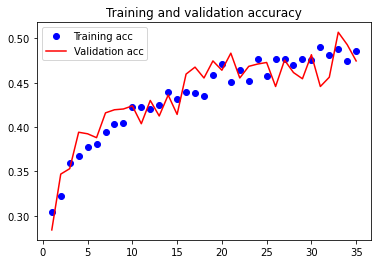

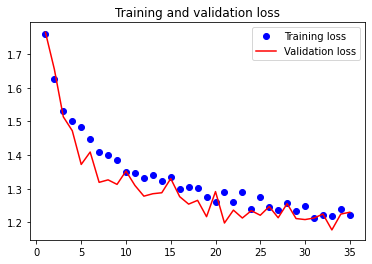

In [33]:
epochs = range(1, len(total_acc) + 1)

plt.plot(epochs, total_acc, 'bo', label='Training acc')
plt.plot(epochs, total_val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, total_loss, 'bo', label='Training loss')
plt.plot(epochs, total_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [34]:
model.save('IRV2+SA_model.hdf5')

In [73]:
# num_classes = 6

# # Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
# model = Sequential()
# model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size[0] , img_size[1] , 3)) )
# model.add(Conv2D(32, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Conv2D(64, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Conv2D(128, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dense(num_classes))

In [74]:
# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 320, 320, 36)      1008      
_________________________________________________________________
activation_4 (Activation)    (None, 320, 320, 36)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 160, 160, 36)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160, 160, 36)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 160, 160, 64)      20800     
_________________________________________________________________
activation_5 (Activation)    (None, 160, 160, 64)     

In [75]:
# model.compile(optimizer='adam' , loss = SparseCategoricalCrossentropy(from_logits=True), 
# #               metrics=['accuracy'])

In [ ]:
# es = EarlyStopping(monitor ="val_loss", 
#                    mode ="min", patience = 5, 
#                    restore_best_weights = True)

# history = model.fit(train_ds , validation_data=val_ds , epochs=40 , callbacks=[es])

Epoch 1/40
